## Aplicação dos métodos

### Importação

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import sklearn.decomposition
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('dados tratados/v1/data.csv')

In [3]:
df = df.drop(['Mau', 'Maa', 'Mag'], axis=1)

In [4]:
df['Abs 1º Pico'] = df['Abs 1º Pico'].replace(np.nan,0)

In [5]:
df['Abs 2º Pico'] = df['Abs 2º Pico'].replace(np.nan,0)

In [6]:
df['Resultado 2'] = list(df['Resultado'].replace('FI','NF'))

### Absorbância 1º Pico

In [7]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:8]
TARGET = ['Abs 1º Pico']
# TARGET = ['Resultado']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [8]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [9]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [10]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [11]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [12]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [13]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [14]:
NUM_EPOCAS = 10000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

9999 tensor(0.0062)


In [15]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [16]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [17]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [18]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 2671.2617492922386


In [19]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {RMSE}')

Loss do teste: 7135639.333231831


### Absorbância 1º e 2º pico

In [20]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:8]
TARGET = ['Abs 1º Pico','Abs 2º Pico']
# TARGET = ['Resultado']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [21]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [22]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [23]:
print(X_treino)
print()
print(y_treino)

tensor([[0.0000, 1.0000, 1.0000, 0.5714, 0.0000, 0.5000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.0521, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.1667, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.5000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.5000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.5000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.4286, 1.0000, 0.1667, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7917, 0.1667, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.8333, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.1042, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.7143, 1.0000, 0.6667, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.4286, 0.2083, 0.5000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8333, 0.1667, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.1667, 0.0000],
        [0

In [24]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [25]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [26]:
for p in minha_MLP.parameters():
    print(p)

Parameter containing:
tensor([[-0.2418, -0.2966, -0.3310,  0.2507, -0.2119, -0.3560, -0.2952],
        [-0.0672,  0.0241, -0.3559, -0.3085, -0.1538,  0.0795,  0.2769],
        [-0.1527, -0.1323,  0.0328, -0.3363, -0.1355,  0.2519, -0.2526],
        [-0.0210,  0.0060,  0.0883,  0.0594,  0.1138,  0.0232, -0.2601],
        [-0.1220, -0.0925,  0.1773, -0.0011,  0.2539, -0.2010,  0.0743],
        [ 0.2609,  0.2385,  0.2354,  0.2768,  0.0962, -0.3121, -0.1960],
        [-0.1902, -0.0655, -0.1442,  0.0311, -0.3726,  0.1327,  0.1505],
        [-0.3646, -0.3685, -0.3536, -0.3082,  0.2233,  0.0536,  0.0114],
        [-0.0960, -0.1590,  0.2821,  0.0486,  0.2311, -0.2744,  0.3027],
        [-0.3107, -0.2622, -0.3042,  0.3682, -0.1832,  0.2241, -0.3511],
        [ 0.1486, -0.1734,  0.1710, -0.1000,  0.2279, -0.2915, -0.3074],
        [-0.1872,  0.2470, -0.1999, -0.1223,  0.2358, -0.3068, -0.1520],
        [ 0.3572, -0.0449,  0.2422, -0.2904,  0.0757, -0.1552, -0.1498],
        [ 0.1274,  0.0074,  0

In [27]:
y_prev = minha_MLP(X_treino)
y_prev

tensor([[-0.2323, -0.1751],
        [-0.2829, -0.2124],
        [-0.2168, -0.1605],
        [-0.3096, -0.2232],
        [-0.2091, -0.1745],
        [-0.3096, -0.2232],
        [-0.1943, -0.1713],
        [-0.1612, -0.1863],
        [-0.2081, -0.1869],
        [-0.2826, -0.2123],
        [-0.2076, -0.1805],
        [-0.2562, -0.2205],
        [-0.3096, -0.2232],
        [-0.1616, -0.1862],
        [-0.2361, -0.1478],
        [-0.2391, -0.1940],
        [-0.2402, -0.1686],
        [-0.3096, -0.2232],
        [-0.2591, -0.2201],
        [-0.2084, -0.1935],
        [-0.1619, -0.1860],
        [-0.2726, -0.2152],
        [-0.1652, -0.1823],
        [-0.1735, -0.1788],
        [-0.2826, -0.2128],
        [-0.2572, -0.2035],
        [-0.3096, -0.2232]], grad_fn=<AddmmBackward0>)

In [28]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [29]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [30]:
NUM_EPOCAS = 10000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

9999 tensor(0.0069)


In [31]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[3.32999998e+00 4.01599993e+03] [  36.58596781 4003.65538609]
[1.41      7.8599998] [-9.86853795 -1.35648242]
[4.40000005e-01 8.06000006e+02] [  2.50189225 800.75484717]
[1306.99996084  912.99997696] [606.13234432 602.37524539]
[841.99997519 875.0000208 ] [850.59746723 871.90779617]
[1691.00001001 2101.99989188] [606.13234432 602.37524539]
[369.00000367   0.72000001] [ 3.79279723e+02 -1.01965265e-01]
[0. 0.] [13.60491452 -2.56707782]
[1.28999994 0.86999998] [5.34338896 0.89878034]
[1341.00005993 3193.99995875] [1332.85258472 3184.60279119]
[781.99997509 820.99997735] [789.93105175 817.89088726]
[2658.9999066  1445.00003296] [2659.07412118 1438.99385834]
[0. 0.] [606.13234432 602.37524539]
[186.99999931   0.        ] [178.90606289   5.54553098]
[385.00000572 777.99999011] [388.63755079 771.08515066]
[2951.00007284 4031.00008428] [2971.13429374 4010.7123338 ]
[3659.00011045 4086.        ] [3691.13575017 4074.64449048]
[0. 0.] [606.13234432 602.37524539]
[2266.00000596 1469.00001168] [226

In [32]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [33]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[   2.82       2574.00000107] [2340.95939726 1928.49873412]
[353.99998849 815.00001311] [848.17106284 657.75667369]
[2925.99994648 3972.9999429 ] [-1149.9434821   4363.17759776]
[2.13000011 2.82999989] [2260.1399647  3346.24527633]


In [34]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 2166.935902288509


In [35]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {RMSE}')

Loss do teste: 4899385.798919681


### Absorbância 1º e 2º pico normalizado

In [36]:
for column in df.columns[1:-2]:
    df[column] = df[column]/df[column].abs().max()

In [37]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(df.columns)[1:8]
TARGET = ['Abs 1º Pico','Abs 2º Pico']

indices = df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [38]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [39]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [40]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [41]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [42]:
y_prev = minha_MLP(X_treino)

In [43]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [44]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [45]:
NUM_EPOCAS = 10000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

9999 tensor(0.0070)


In [46]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [47]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=7, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [48]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [49]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.5931210272817459


In [50]:
RMSE = mean_squared_error(y_true, y_pred)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.3521181407186322


### Análise das épocas absorbância 1º e 2º pico

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [52]:
X = df.iloc[:,1:9].values
y = df.iloc[:,-5:-3].values

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X)
normalizador_y.fit(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

model = MLP(num_dados_entrada=X_tensor.shape[1], neuronios_c1=50, neuronios_c2=20, num_targets=y_tensor.shape[1])

num_epochs = 20000

loss_values, acc_values = [], []

dataset = TensorDataset(X_tensor, y_tensor)

# Define o otimizador
optimizer = optim.SGD(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

min_loss = float('inf')
min_loss_value = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss,num_batches = 0.0,0  # Variável para armazenar a perda da época atual

    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    total,correct = 0,0
        
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        mse = torch.mean((outputs - labels) ** 2)
        
        # _, predicted = torch.max(outputs.data,1)
        
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()

        num_batches += 1
    
    epoch_loss /= num_batches 
    epoch_loss = np.sqrt(epoch_loss)
    
    loss_values.append(epoch_loss)
    acc_values.append(np.sqrt(mse.item()))
    
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        min_loss_value = outputs
        min_loss_params = model.state_dict()
        min_loss_features = inputs

Valor mínimo da perda: 0.2386

Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.2500, 0.8621, 0.2857, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.3448, 0.5714, 1.0000, 0.0333])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.6667, 1.0000, 1.0000, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.3448, 0.5714, 1.0000, 0.6667])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.3448, 0.5714, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.1724, 0.5714, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.3448, 0.4286, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 0.5063, 0.5000, 0.3333, 1.0000, 0.2857, 0.0000, 0.0000])
Valores das features: tensor([1.0000, 1.0000, 1.0000, 0.5000, 0.3448, 0.1429, 0.0000, 0.0000])
Valores das features: tensor([0.2500, 1.0000, 1.0000, 0.5833, 0.1724, 0.5714, 0.0000, 0.0000])
Valores das feature

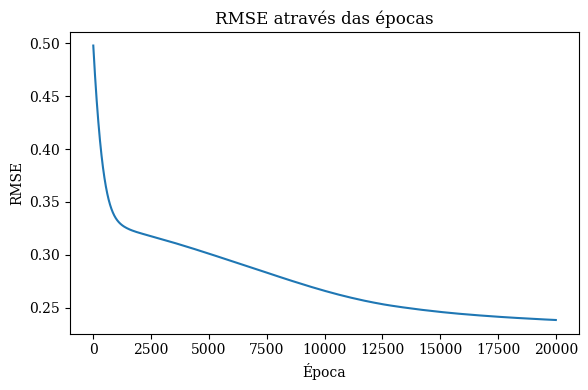

In [78]:
print(f"Valor mínimo da perda: {round(min_loss,4)}")

print()

for feature_values in min_loss_features:
    print(f"Valores das features: {feature_values}")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.figure(figsize=(6,4))

# plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.title('RMSE através das épocas')

# plt.subplot(1,2,2)
# plt.plot(range(1, num_epochs + 1), acc_values)
# plt.xlabel('Época')
# plt.ylabel('Accuracy')
# plt.title('Gráfico de acurácia')

plt.tight_layout()
plt.savefig('figs/rmse.png')
plt.show()

### Absorbância 1 e 2 - PCA

#### PCA

In [54]:
X = df.iloc[:,1:9]

In [55]:
pca = sklearn.decomposition.PCA(n_components=2)

In [56]:
pca.fit(X)

PCA(n_components=2)

In [57]:
X_pca = pca.transform(X)

#### Regressão

In [58]:
novo_df = pd.DataFrame(X_pca,columns=['PC1','PC2'])
novo_df['Target 1'] = df['Abs 1º Pico']
novo_df['Target 2'] = df['Abs 2º Pico']

In [59]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2319
FEATURES = list(novo_df.columns)[:2]
TARGETS = ['Target 1','Target 2']

indices = novo_df.index
indices_treino, indices_teste = train_test_split(indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

df_treino = novo_df.loc[indices_treino]
df_teste = novo_df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGETS, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGETS, axis=1)

In [60]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [61]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [62]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 50
NEURONIOS_C2 = 20

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [63]:
y_prev = minha_MLP(X_treino)

In [64]:
TAXA_DE_APRENDIZADO = 0.01

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [65]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [66]:
NUM_EPOCAS = 10000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # mostra resultado

print(epoca, loss.data)

9999 tensor(0.0101)


In [67]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [68]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [69]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

In [70]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {round(RMSE,4)}')

Loss do teste: 0.0949


### Gráfico de Real x Predito PCA

In [71]:
y_true_1,y_true_2 = [],[]
y_pred_1,y_pred_2 = [],[]

for i in range(len(y_pred)):
    
    y_pred_1.append(y_pred[i][0])
    y_pred_2.append(y_pred[i][1])
    
    y_true_1.append(y_true[i][0])
    y_true_2.append(y_true[i][1])

In [72]:
model = LinearRegression()
m1 = model.fit(np.array(y_true_1).reshape((-1, 1)), y_pred_1)

model = LinearRegression()
m2 = model.fit(np.array(y_true_2).reshape((-1, 1)), y_pred_2)

In [73]:
def f(x,m):
    return m.intercept_ + x*m.coef_

In [74]:
x_plot_1 = np.linspace(min(y_true_1),max(y_true_1),10)
y_plot_1 = f(x_plot_1,m1)

x_plot_2 = np.linspace(min(y_true_2),max(y_true_2),10)
y_plot_2 = f(x_plot_2,m2)

In [75]:
s1,s2 = m1.score(np.array(y_true_1).reshape((-1, 1)),y_pred_1),m2.score(np.array(y_true_2).reshape((-1, 1)),y_pred_2)

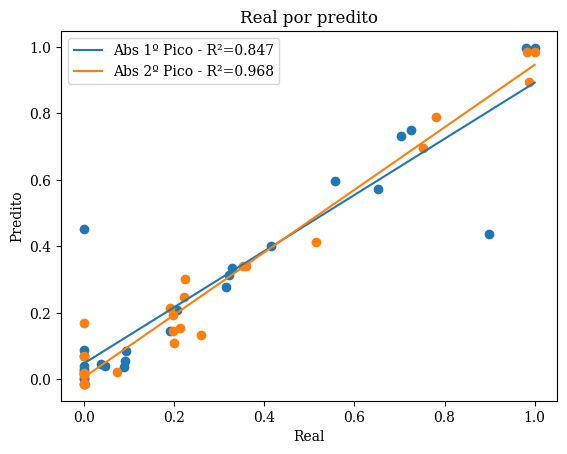

In [79]:
plt.scatter(y_true_1,y_pred_1),plt.scatter(y_true_2,y_pred_2)
plt.plot(x_plot_1,y_plot_1,label=f'Abs 1º Pico - R²={round(s1,3)}')
plt.plot(x_plot_2,y_plot_2,label=f'Abs 2º Pico - R²={round(s2,3)}')

plt.title('Real por predito'),plt.xlabel('Real'),plt.ylabel('Predito')

plt.legend()
plt.savefig('figs/realXpredito_pca.png')
plt.show()